<a href="https://colab.research.google.com/github/Jerryson520/NLP-with-disaster-tweets/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import re
import random
import pickle
from collections import defaultdict
from collections import Counter

# PyTorch related packages a
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

#
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score


##
# from spellchecker import SpellChecker

# import gensim
import string
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# Random Seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')

    print(f'There\'re {torch.cuda.device_count()} available')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')

else:
    print('No GPU available ...')
    device = torch.device('cpu')

There're 1 available
We will use the GPU: NVIDIA A100-SXM4-40GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls /content/drive/MyDrive/NLP-with-tweets/

dataset.pkl  Model-Training.ipynb  test_dataset.pkl


In [15]:
with open('/content/drive/MyDrive/NLP-with-tweets/dataset.pkl', 'rb') as f:
  dataset = pickle.load(f)


with open('/content/drive/MyDrive/NLP-with-tweets/test_dataset.pkl', 'rb') as f:
  test_dataset = pickle.load(f)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = BATCH_SIZE
    )


val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-large-uncased',
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [18]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6,
                  eps = 1e-8)


NUM_EPOCHS = 3

total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=8, num_training_steps=total_steps)

In [29]:
import torch.nn.functional as F

def flat_accuracy(preds, labels):
    """Calculate accuracy after converting logits to probabilities."""

    probs = F.softmax(torch.tensor(preds), dim=1)  # Convert logits to probabilities
    pred_flat = torch.argmax(probs, dim=1).cpu().numpy().flatten()  # Get predicted class
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    """Calculate F1-score after converting logits to probabilities."""

    probs = F.softmax(torch.tensor(preds), dim=1)  # Convert logits to probabilities
    pred_flat = torch.argmax(probs, dim=1).cpu().numpy().flatten()  # Get predicted class
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [34]:
import time
import datetime
from tqdm import tqdm

training_stats = []

for epoch_i in range(NUM_EPOCHS):
    print(f"\n{'='*20} Epoch {epoch_i + 1} / {NUM_EPOCHS} {'='*20}\n")

    start_time = time.time()

    # === Training Phase ===
    print("🚀 Training...")
    total_train_loss = 0
    model.train()

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i + 1}", leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        optimizer.zero_grad()

        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
        loss, logits = res.loss, res.logits

        total_train_loss += loss.item()

        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_dataloader)

    print(f"\n✅ Epoch {epoch_i + 1} Training Completed!")
    print(f"📉 Average Training Loss: {avg_train_loss:.4f}")

    # === Validation Phase ===
    print("\n🔍 Running Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    for batch in tqdm(val_dataloader, desc="Validating", leave=False):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
            loss, logits = res.loss, res.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_f1 = total_eval_f1 / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # === Time Tracking ===
    epoch_time = str(datetime.timedelta(seconds=int(time.time() - start_time)))

    print(f"\n📊 Validation Results - Epoch {epoch_i + 1}")
    print(f"📌 Average Validation Accuracy: {avg_val_accuracy:.4f}")
    print(f"📌 Average Validation F1 Score: {avg_val_f1:.4f}")
    print(f"📉 Average Validation Loss: {avg_val_loss:.4f}")
    print(f"⏳ Time Elapsed: {epoch_time}")

    # Record statistics
    training_stats.append({
        "epoch": epoch_i + 1,
        "Training Loss": avg_train_loss,
        "Validation Loss": avg_val_loss,
        "Validation Accuracy": avg_val_accuracy,
        "Validation F1": avg_val_f1,
        "Time": epoch_time
    })

print("\n🎉 Training Complete!")



==================== Epoch 1 / 3 ====================

🚀 Training...



✅ Epoch 1 Training Completed!
📉 Average Training Loss: 0.2945

🔍 Running Validation...



📊 Validation Results - Epoch 1
📌 Average Validation Accuracy: 0.8400
📌 Average Validation F1 Score: 0.7938
📉 Average Validation Loss: 0.4103
⏳ Time Elapsed: 0:01:10

==================== Epoch 2 / 3 ====================

🚀 Training...



✅ Epoch 2 Training Completed!
📉 Average Training Loss: 0.2940

🔍 Running Validation...



📊 Validation Results - Epoch 2
📌 Average Validation Accuracy: 0.8400
📌 Average Validation F1 Score: 0.7938
📉 Average Validation Loss: 0.4103
⏳ Time Elapsed: 0:01:10

==================== Epoch 3 / 3 ====================

🚀 Training...



✅ Epoch 3 Training Completed!
📉 Average Training Loss: 0.2938

🔍 Running Validation...



📊 Validation Results - Epoch 3
📌 Average Validation Accuracy: 0.8400
📌 Average Validation F1 Score: 0.7938
📉 Average Validation Loss: 0.4103
⏳ Time Elapsed: 0:01:10

🎉 Training Complete!


In [37]:
# Display floats with two decimal places.

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

,Training Loss,Validation Loss,Validation Accuracy,Validation F1,Time
epoch,,,,,
1,0.294535,0.410339,0.840015,0.793768,0:01:10
2,0.293952,0.410339,0.840015,0.793768,0:01:10
3,0.293839,0.410339,0.840015,0.793768,0:01:10


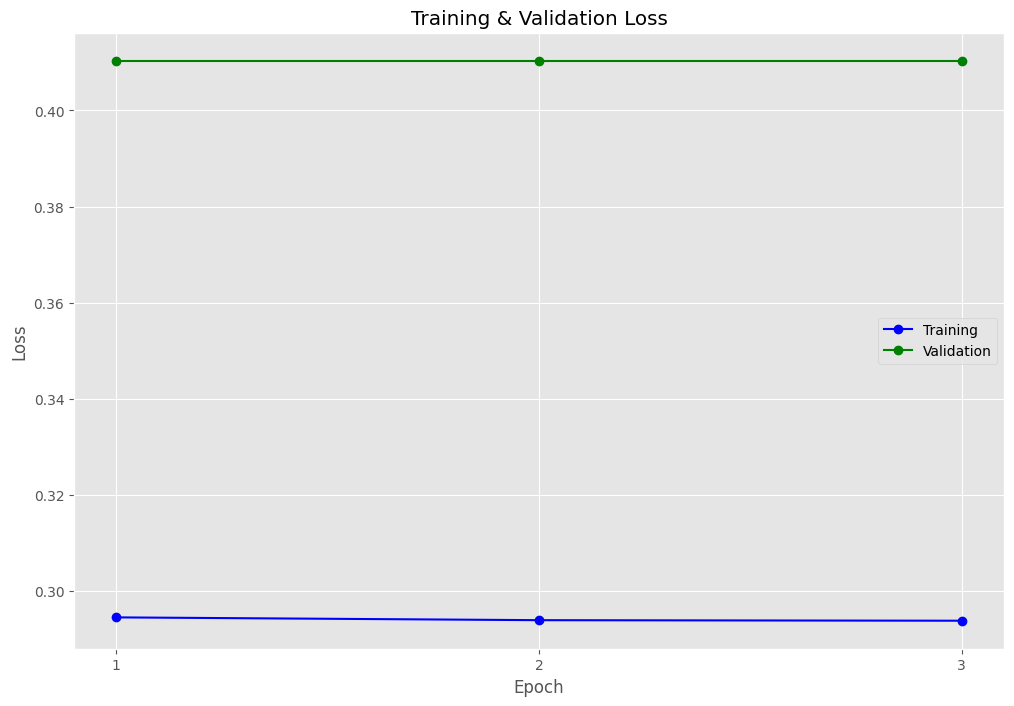

In [40]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [52]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [79]:
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

In [80]:
# Prediction on test set:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset.tensors[0])))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in test_dataloader:
  b_input_ids = batch[0].to(device).to(torch.int64)
  b_input_mask = batch[1].to(device).to(torch.int64)

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:
      res = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  labels=None)
      logits = res.logits

  # logits = outputs[0]

  # Move logits and labels to CPU:

  logits = logits.detach().cpu().numpy()
  probs = F.softmax(torch.tensor(logits), dim=1)  # Convert logits to probabilities
  pred_flat = torch.argmax(probs, dim=1).cpu().numpy().flatten()  # Get predicted class


  # Store predictions and true labels:

  predictions.extend(pred_flat)


print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [81]:
len(predictions)

3263

In [83]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP-with-tweets/test.csv')

In [85]:
test_df['target'] = predictions

In [93]:
result = test_df[['id', 'target']]
result.to_csv('/content/drive/MyDrive/NLP-with-tweets/submission.csv', index=False)

In [91]:
test_df[['id', 'target']]

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [89]:
pd.read_csv('/content/drive/MyDrive/NLP-with-tweets/sample_submission.csv')

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
